# DQN

In [158]:
#importing necessary packages
import gym
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [159]:
#getting the device 
#cuda if gpu else cpu
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

### Cartpole environment

In [160]:
env=gym.make("CartPole-v0")

### Network

In [161]:
#creating the neural network
class Network(nn.Module):
    def __init__(self,in_dimension,out_dimension):
        super(Network,self).__init__()
        #nn model
        self.layers=nn.Sequential(
            nn.Linear(in_dimension,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.Linear(128,out_dimension)
        )
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        #forward propagation
        return self.layers(x)   

### Replay buffer

In [162]:
class ReplayBuffer:
    def __init__(self,obs_dim,size,batch_size:int=32):
        
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
    def store(self,obs,act,rew,next_obs,done):
        #storing all necesary info
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    def sample_batch(self) -> Dict[str, np.ndarray]:
        #sampling the replay buffer
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],next_obs=self.next_obs_buf[idxs],acts=self.acts_buf[idxs],rews=self.rews_buf[idxs],done=self.done_buf[idxs])
    def __len__(self):
        return self.size

In [163]:
class DQN:
    def __init__(self,env,memory_size,batch_size,target_update,epsilon_decay,max_epsilon=1.00,min_epsilon=0.1,gamma=0.99):
        #state size and action size
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        #environment,epsilon and discount factor
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        #network
        self.dqn = Network(obs_dim, action_dim).to(device)
        self.dqn_target = Network(obs_dim, action_dim).to(device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        #optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())
        #transition to store in memory
        self.transition = list()
        # mode: train or test
        self.is_test = False
        
    def select_action(self,state)->np.ndarray:
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(device)).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    def step(self,action)->Tuple[np.ndarray, np.float64, bool]:
        #Take an action and return the response of the environment
        next_state, reward, done, _ = self.env.step(action)
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
        return next_state, reward, done
    def update_model(self) -> torch.Tensor:
        #Update the model by gradient descent
        samples = self.memory.sample_batch()
        loss = self._compute_dqn_loss(samples)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    def train(self,num_frames,plotting_interval=200):
        #train the agent
        self.is_test = False
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0
        for frame_idx in range(1,num_frames+1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            state = next_state
            score += reward
            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0
            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                # linearly decrease epsilon
                self.epsilon = max(self.min_epsilon,self.epsilon-(self.max_epsilon - self.min_epsilon) * self.epsilon_decay)
                epsilons.append(self.epsilon)
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
                # plotting
                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, epsilons)
        self.env.close()
    def test(self) -> List[np.ndarray]:
        #testing the agent
        self.is_test = True
        state = self.env.reset()
        done = False
        score = 0
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            state = next_state
            score += reward
        print("score: ", score)
        self.env.close()
        return frames
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        #Return dqn loss.
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r   otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(device)
        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)
        return loss
    def _target_hard_update(self):
        #Hard update: target <- local
        self.dqn_target.load_state_dict(self.dqn.state_dict())
    def _plot(self,frame_idx,scores,losses,epsilons):
        #Plot the training progresses
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

In [164]:
# parameters
num_frames = 20000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQN(env, memory_size, batch_size, target_update, epsilon_decay)

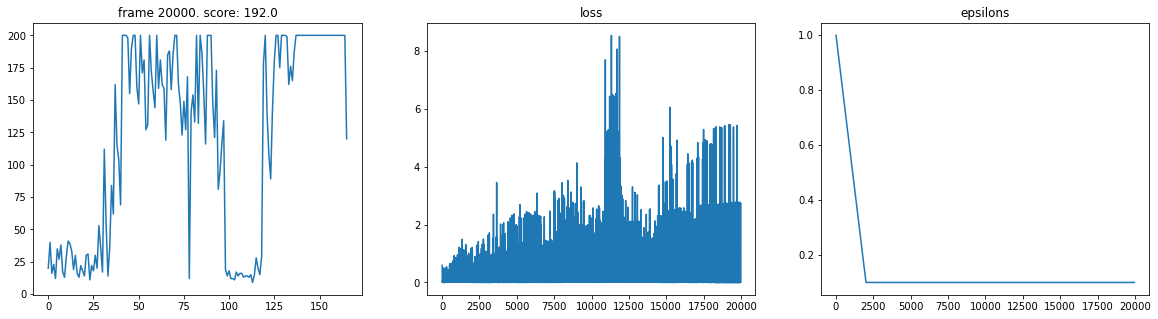

In [165]:
agent.train(num_frames)

In [167]:
frames = agent.test()

score:  200.0
